In [1]:
import logging as logger
import os
import shutil
import tarfile
from csv import reader
import logging as logger
import os
import shutil
import tarfile
from csv import reader

import cv2
import pandas as pd
import seaborn as sns

In [2]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a dark background
set_style("whitegrid")

In [3]:
from usefunc import findangamp,findang
from usefunc import mostvalue, possibleaction,findpacman
from usefunc import pickaction
from usefunc import accuracy
from usefunc import fretwo,findobject

# 1. Data loading

### load transformed .csv data

In [4]:
df=pd.read_csv("593_RZ_5037271_Aug-05-15-35-12.csv")
df.head()

,frame_id,score,duration,unclipped_reward,action,gaze_position_x,gaze_position_y
0,RZ_5037271_1,66481,611,0,0,79.85,105.17
1,RZ_5037271_1,66481,611,0,0,79.84,105.30
2,RZ_5037271_1,66481,611,0,0,79.83,105.30
3,RZ_5037271_1,66481,611,0,0,79.80,105.05
4,RZ_5037271_1,66481,611,0,0,79.79,104.78


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881897 entries, 0 to 881896
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   frame_id          881897 non-null  object 
 1   score             881897 non-null  int64  
 2   duration          881897 non-null  int64  
 3   unclipped_reward  881897 non-null  int64  
 4   action            881897 non-null  int64  
 5   gaze_position_x   881897 non-null  float64
 6   gaze_position_y   881897 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 47.1+ MB


### a. only choose the duration between 0ms and 100ms, since the duration outside this range is rare(~1%)
### b. pick out data with up, down, left, right action. 
### c. remapping the index of action from 2: up, 3: right, 4: left, 5: down to 0: up, 1: right, 2: left, 3: down

In [6]:
df=df[(df['duration']>0) & (df['duration']<100)].copy().reset_index(drop=True)
df=df.drop(columns=['score', 'duration','unclipped_reward'])
df1=df[(df['action']==2) | (df['action']==3) | (df['action']==4) | (df['action']==5)].copy().reset_index(drop=True)
dict_map = {2:0,3:1,4:2,5:3}   #  0:up,  1:right,  2:left,  3:down
df1['action'] = df1['action'].map(dict_map)
df1.head()

,frame_id,action,gaze_position_x,gaze_position_y
0,RZ_5037271_4,0,121.71,70.90
1,RZ_5037271_4,0,121.66,70.92
2,RZ_5037271_4,0,121.65,71.10
3,RZ_5037271_4,0,121.66,71.22
4,RZ_5037271_4,0,121.69,71.22


### combine all x,y position of the same frame into a single unit as a np array

In [7]:
uniqueid=df1['frame_id'].unique()#find all unique frame_id
frame_id=[]
action=[]
xyarray=[]
for idnum in uniqueid:#iterate through all frame id
    xy=[]
#     print(idnum)
    dataf=df1[df1['frame_id']==idnum]#find the data with same frame_id as dataf
    #print(len(dataf.index))
    for ind in dataf.index:
        #print(ind)
        xy.append([df1.iloc[ind]['gaze_position_x'],df1.iloc[ind]['gaze_position_y']])#append all coordinate in a same frame_id
    xy=np.array(xy)
    firstindex=dataf.index[0]
    frame_id.append(df1.iloc[firstindex]['frame_id'])
    action.append(df1.iloc[firstindex]['action'])
    xyarray.append(xy)
df2=pd.DataFrame({'frame_id':frame_id,'action':action,
                      'xyarray':xyarray})
print(df2.head())
    

       frame_id  action                                            xyarray
0  RZ_5037271_4       0  [[121.71, 70.9], [121.66, 70.92], [121.65, 71....
1  RZ_5037271_5       0  [[121.64, 71.35], [121.65, 71.38], [121.64, 71...
2  RZ_5037271_6       0  [[121.5, 71.12], [121.51, 71.03], [121.47, 70....
3  RZ_5037271_7       0  [[121.26, 71.35], [121.31, 71.33], [121.34, 71...
4  RZ_5037271_8       0  [[121.28, 70.6], [121.26, 70.6], [121.26, 70.4...


# 2. Extracting some features

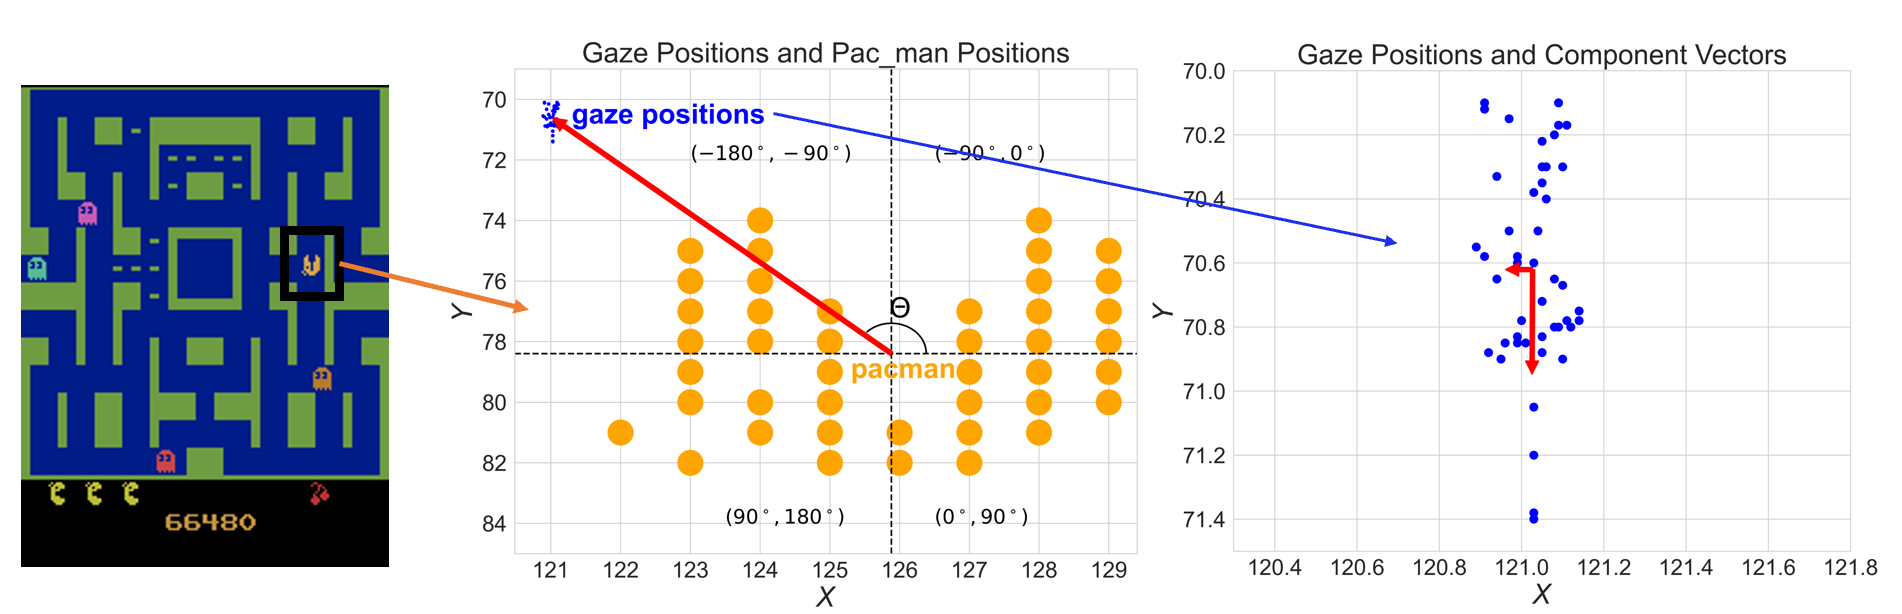

### using pca to extract mean position, start position, end position, variance, component of gaze positions in each frame

In [8]:
from sklearn.decomposition import PCA
frame_id=[]
action=[]
start=[]
end=[]
mean=[]
variance0=[]
component0=[]
variance1=[]
component1=[]
for ind in df2.index:#iterate all frames
    if np.size(df2.iloc[ind]['xyarray'],axis=None)>=5:
        frame_id.append(df2.iloc[ind]['frame_id'])
        action.append(df2.iloc[ind]['action'])
        X=df2.iloc[ind]['xyarray']#X contains all gaze positions in one frame
        start.append(X[0].tolist())#store the start point 
        end.append(X[-1].tolist())#store the end point
        #using PCA to get the mean point, variance & component for two axes
        pca = PCA(2)
        pca.fit(X)
        mean.append(pca.mean_.tolist())
        variance0.append(pca.explained_variance_[0])
        component0.append(pca.components_[0].tolist())
        variance1.append(pca.explained_variance_[1])
        component1.append(pca.components_[1].tolist())
    else:
        continue
#creat new dateframe
pcadf=pd.DataFrame({'frame_id':frame_id,'action':action,
                    'gaze_mean':mean,'gaze_start':start,'gaze_end':end,
                   'gaze_variance0':variance0,'gaze_component0':component0,
                   'gaze_variance1':variance1,'gaze_component1':component1})
pcadf.head()

,frame_id,action,gaze_mean,gaze_start,gaze_end,gaze_variance0,gaze_component0,gaze_variance1,gaze_component1
0,RZ_5037271_4,0,"[121.63199999999995, 71.26759999999999]","[121.71, 70.9]","[121.62, 71.3]",0.035883,"[0.29259381909635307, -0.9562368205766868]",0.003952,"[-0.9562368205766868, -0.29259381909635307]"
1,RZ_5037271_5,0,"[121.51607843137252, 71.19333333333334]","[121.64, 71.35]","[121.45, 71.17]",0.029144,"[-0.13066806163070968, -0.9914261735851403]",0.004015,"[0.9914261735851403, -0.13066806163070968]"
2,RZ_5037271_6,0,"[121.37160000000002, 71.23140000000001]","[121.5, 71.12]","[121.21, 71.35]",0.070980,"[-0.13137677861987765, 0.9913325083136654]",0.008503,"[0.9913325083136654, 0.13137677861987765]"
3,RZ_5037271_7,0,"[121.33439999999999, 70.77199999999999]","[121.26, 71.35]","[121.28, 70.6]",0.047391,"[-0.10360327724892186, 0.9946187012837046]",0.008704,"[-0.9946187012837046, -0.10360327724892186]"
4,RZ_5037271_8,0,"[121.22420000000002, 71.00439999999999]","[121.28, 70.6]","[121.25, 71.1]",0.054097,"[0.1058567028814862, -0.994381394865703]",0.008667,"[-0.994381394865703, -0.1058567028814862]"


In [9]:
pcadf.to_csv('pcadf.csv',index=False)#save it for future use

### extract the position of pac_man and possible action in each frame (here we only consider four possible action directions: up, right, left, down.)

In [10]:
#pcadf=pd.read_csv('pcadf.csv')

In [11]:
import cv2 
import numpy as np
# path 
pac_position=[]# store the position of pac_man in each frame
poss_action=[]# store the possible action in each frame
for pic in pcadf['frame_id']:#iterate through all images
    path = r"D:\erdos\atari-HEAD\cleaned_data\all_images\\"+pic+".png" #not included in the repository file, and all_images file should inclue all images in the
                                        #trial 593_RZ_5037271_Aug-05-15-35-12
    src = cv2.imread(path)#read each image
    image = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY )# Using cv2.COLOR_BGR2GRAY color space
    #print(image)
    pac_position.append(findpacman(image,167)[0])#167 is the color space of pac_man
    poss_action.append(findpacman(image,167)[1])
dfpac_position=pd.DataFrame({'pac_position':pac_position,'pos_action':poss_action})
df3=pd.concat([pcadf,dfpac_position],axis=1)
df3=df3.dropna().reset_index(drop=True)
df3.head()

,frame_id,action,gaze_mean,gaze_start,gaze_end,gaze_variance0,gaze_component0,gaze_variance1,gaze_component1,pac_position,pos_action
0,RZ_5037271_4,0,"[121.63199999999995, 71.26759999999999]","[121.71, 70.9]","[121.62, 71.3]",0.035883,"[0.29259381909635307, -0.9562368205766868]",0.003952,"[-0.9562368205766868, -0.29259381909635307]","[125.88372093023256, 84.3953488372093]","[0, 2, 3]"
1,RZ_5037271_5,0,"[121.51607843137252, 71.19333333333334]","[121.64, 71.35]","[121.45, 71.17]",0.029144,"[-0.13066806163070968, -0.9914261735851403]",0.004015,"[0.9914261735851403, -0.13066806163070968]","[125.88372093023256, 84.3953488372093]","[0, 2, 3]"
2,RZ_5037271_6,0,"[121.37160000000002, 71.23140000000001]","[121.5, 71.12]","[121.21, 71.35]",0.070980,"[-0.13137677861987765, 0.9913325083136654]",0.008503,"[0.9913325083136654, 0.13137677861987765]","[125.91525423728814, 81.61016949152543]","[0, 1, 2, 3]"
3,RZ_5037271_7,0,"[121.33439999999999, 70.77199999999999]","[121.26, 71.35]","[121.28, 70.6]",0.047391,"[-0.10360327724892186, 0.9946187012837046]",0.008704,"[-0.9946187012837046, -0.10360327724892186]","[125.91525423728814, 81.61016949152543]","[0, 1, 2, 3]"
4,RZ_5037271_8,0,"[121.22420000000002, 71.00439999999999]","[121.28, 70.6]","[121.25, 71.1]",0.054097,"[0.1058567028814862, -0.994381394865703]",0.008667,"[-0.994381394865703, -0.1058567028814862]","[125.91525423728814, 79.61016949152543]","[0, 1, 2, 3]"


### extract the nearest ghost position relative to the pac_man

In [12]:
import cv2 
import numpy as np
# path 
ghost_amp=[]
ghost_angle=[]
for pic in df3['frame_id']:#iterate through all images
    #print(type(pic))
    path = r"D:\erdos\atari-HEAD\cleaned_data\all_images\\"+pic+".png" #not included in the repository file, and all_images file should inclue all images in the
                                        #trial 593_RZ_5037271_Aug-05-15-35-12
    src = cv2.imread(path)#read each image
    image = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY )# Using cv2.COLOR_BGR2GRAY color space
    #print(image)
    pac=df3[df3['frame_id']==pic]['pac_position'].values[0]
    #print(type(pac))
    #print(pac)
    objectlist=findobject(image,pac)
    ghost_amp.append(objectlist[1])
    ghost_angle.append(objectlist[0])
dfghost_position=pd.DataFrame({'ghost_amp':ghost_amp,'ghost_angle':ghost_angle})
df4=pd.concat([df3,dfghost_position],axis=1)
df4.reset_index(drop=True)
df4.head()

,frame_id,action,gaze_mean,gaze_start,gaze_end,gaze_variance0,gaze_component0,gaze_variance1,gaze_component1,pac_position,pos_action,ghost_amp,ghost_angle
0,RZ_5037271_4,0,"[121.63199999999995, 71.26759999999999]","[121.71, 70.9]","[121.62, 71.3]",0.035883,"[0.29259381909635307, -0.9562368205766868]",0.003952,"[-0.9562368205766868, -0.29259381909635307]","[125.88372093023256, 84.3953488372093]","[0, 2, 3]",44.150837,79.934677
1,RZ_5037271_5,0,"[121.51607843137252, 71.19333333333334]","[121.64, 71.35]","[121.45, 71.17]",0.029144,"[-0.13066806163070968, -0.9914261735851403]",0.004015,"[0.9914261735851403, -0.13066806163070968]","[125.88372093023256, 84.3953488372093]","[0, 2, 3]",43.987088,81.217296
2,RZ_5037271_6,0,"[121.37160000000002, 71.23140000000001]","[121.5, 71.12]","[121.21, 71.35]",0.070980,"[-0.13137677861987765, 0.9913325083136654]",0.008503,"[0.9913325083136654, 0.13137677861987765]","[125.91525423728814, 81.61016949152543]","[0, 1, 2, 3]",46.737023,81.776845
3,RZ_5037271_7,0,"[121.33439999999999, 70.77199999999999]","[121.26, 71.35]","[121.28, 70.6]",0.047391,"[-0.10360327724892186, 0.9946187012837046]",0.008704,"[-0.9946187012837046, -0.10360327724892186]","[125.91525423728814, 81.61016949152543]","[0, 1, 2, 3]",46.604505,82.993701
4,RZ_5037271_8,0,"[121.22420000000002, 71.00439999999999]","[121.28, 70.6]","[121.25, 71.1]",0.054097,"[0.1058567028814862, -0.994381394865703]",0.008667,"[-0.994381394865703, -0.1058567028814862]","[125.91525423728814, 79.61016949152543]","[0, 1, 2, 3]",48.590183,83.281367


### calculate the angle and amplitude of the vector connecting gaze (mean,start,end) position and pac_man position. Also transform the pca component of gaze_position to an angle value.

In [13]:
mean_angle=[] #store the angle of the vector connecting mean gaze position and pac_man position
mean_amplitude=[]#store the amplitude of the vector connecting mean gaze position and pac_man position
start_angle=[]#store the angle of the vector connecting start gaze position and pac_man position
start_amplitude=[]#store the amplitude of the vector connecting start gaze position and pac_man position
end_angle=[]#store the angle of the vector connecting end gaze position and pac_man position
end_amplitude=[]#store the amplitude of the vector connecting end gaze position and pac_man positionstart
com_angle0=[]#store the angle of the first component vector in the gaze positions
com_angle1=[]#store the angle of the second component vector in the gaze positions
for ind in df4.index:
    #print(df4.iloc[ind]['gaze_mean'])
    #print(df4.iloc[ind]['gaze_mean'][0])
    meandiff=df4.iloc[ind]['gaze_mean']-df4.iloc[ind]['pac_position']
    #print(meandiff)
    mean_angle.append(findangamp(meandiff[0],meandiff[1])[0])
    mean_amplitude.append(findangamp(meandiff[0],meandiff[1])[1])
    
    startdiff=df4.iloc[ind]['gaze_start']-df4.iloc[ind]['pac_position']
    start_angle.append(findangamp(startdiff[0],startdiff[1])[0])
    start_amplitude.append(findangamp(startdiff[0],startdiff[1])[1])
    
    enddiff=df4.iloc[ind]['gaze_end']-df4.iloc[ind]['pac_position']
    end_angle.append(findangamp(enddiff[0],enddiff[1])[0])
    end_amplitude.append(findangamp(enddiff[0],enddiff[1])[1])
    
    comp0=df4.iloc[ind]['gaze_component0']
    com_angle0.append(findang(comp0[0],comp0[1]))
    
    comp1=df4.iloc[ind]['gaze_component1']
    com_angle1.append(findang(comp1[0],comp1[1]))
mean_angle_amp=pd.DataFrame({'mean_angle':mean_angle,'mean_amplitude':mean_amplitude})
start_angle_amp=pd.DataFrame({'start_angle':start_angle,'start_amplitude':start_amplitude})
end_angle_amp=pd.DataFrame({'end_angle':end_angle,'end_amplitude':end_amplitude})
com_angle0_df=pd.DataFrame({'com_angle0':com_angle0})
com_angle1_df=pd.DataFrame({'com_angle1':com_angle1})

df5=pd.concat([df4,mean_angle_amp,start_angle_amp,end_angle_amp,com_angle0_df,com_angle1_df],axis=1)
df5=df5.dropna()#create new dataframegaze_
df5.head()

,frame_id,action,gaze_mean,gaze_start,gaze_end,gaze_variance0,gaze_component0,gaze_variance1,gaze_component1,pac_position,...,ghost_amp,ghost_angle,mean_angle,mean_amplitude,start_angle,start_amplitude,end_angle,end_amplitude,com_angle0,com_angle1
0,RZ_5037271_4,0,"[121.63199999999995, 71.26759999999999]","[121.71, 70.9]","[121.62, 71.3]",0.035883,"[0.29259381909635307, -0.9562368205766868]",0.003952,"[-0.9562368205766868, -0.29259381909635307]","[125.88372093023256, 84.3953488372093]",...,44.150837,79.934677,-107.945729,13.799091,-107.185325,14.126018,-108.034756,13.771982,-72.986692,-162.986692
1,RZ_5037271_5,0,"[121.51607843137252, 71.19333333333334]","[121.64, 71.35]","[121.45, 71.17]",0.029144,"[-0.13066806163070968, -0.9914261735851403]",0.004015,"[0.9914261735851403, -0.13066806163070968]","[125.88372093023256, 84.3953488372093]",...,43.987088,81.217296,-108.305842,13.905737,-108.019981,13.718247,-108.533426,13.948754,-97.508199,-7.508199
2,RZ_5037271_6,0,"[121.37160000000002, 71.23140000000001]","[121.5, 71.12]","[121.21, 71.35]",0.070980,"[-0.13137677861987765, 0.9913325083136654]",0.008503,"[0.9913325083136654, 0.13137677861987765]","[125.91525423728814, 81.61016949152543]",...,46.737023,81.776845,-113.643011,11.329768,-112.825956,11.381482,-114.635915,11.287626,97.549158,7.549158
3,RZ_5037271_7,0,"[121.33439999999999, 70.77199999999999]","[121.26, 71.35]","[121.28, 70.6]",0.047391,"[-0.10360327724892186, 0.9946187012837046]",0.008704,"[-0.9946187012837046, -0.10360327724892186]","[125.91525423728814, 81.61016949152543]",...,46.604505,82.993701,-112.911807,11.766484,-114.404793,11.266875,-112.830973,11.946105,95.946701,-174.053299
4,RZ_5037271_8,0,"[121.22420000000002, 71.00439999999999]","[121.28, 70.6]","[121.25, 71.1]",0.054097,"[0.1058567028814862, -0.994381394865703]",0.008667,"[-0.994381394865703, -0.1058567028814862]","[125.91525423728814, 79.61016949152543]",...,48.590183,83.281367,-118.595054,9.801289,-117.223417,10.132558,-118.731446,9.705029,-83.923473,-173.923473


### set new dataframe with needed features

In [14]:
df6=df5.drop(['gaze_mean','gaze_start','gaze_end','gaze_component0','gaze_component1','pac_position'],axis=1).copy().reset_index(drop=True)
df6.head()

,frame_id,action,gaze_variance0,gaze_variance1,pos_action,ghost_amp,ghost_angle,mean_angle,mean_amplitude,start_angle,start_amplitude,end_angle,end_amplitude,com_angle0,com_angle1
0,RZ_5037271_4,0,0.035883,0.003952,"[0, 2, 3]",44.150837,79.934677,-107.945729,13.799091,-107.185325,14.126018,-108.034756,13.771982,-72.986692,-162.986692
1,RZ_5037271_5,0,0.029144,0.004015,"[0, 2, 3]",43.987088,81.217296,-108.305842,13.905737,-108.019981,13.718247,-108.533426,13.948754,-97.508199,-7.508199
2,RZ_5037271_6,0,0.070980,0.008503,"[0, 1, 2, 3]",46.737023,81.776845,-113.643011,11.329768,-112.825956,11.381482,-114.635915,11.287626,97.549158,7.549158
3,RZ_5037271_7,0,0.047391,0.008704,"[0, 1, 2, 3]",46.604505,82.993701,-112.911807,11.766484,-114.404793,11.266875,-112.830973,11.946105,95.946701,-174.053299
4,RZ_5037271_8,0,0.054097,0.008667,"[0, 1, 2, 3]",48.590183,83.281367,-118.595054,9.801289,-117.223417,10.132558,-118.731446,9.705029,-83.923473,-173.923473


### create four columns ['0','1','2','3'], and store the information of possible action. For example, if possible action if [1,2], than the value in ['0'] column is 0, the value in ['1'] column is 1, the value in ['2'] column is 1, the value in ['3'] column is 0,

In [15]:
df6['0'] = df6['pos_action'].map(lambda x: pickaction(x,0) )
df6['1'] = df6['pos_action'].map(lambda x: pickaction(x,1) )
df6['2'] = df6['pos_action'].map(lambda x: pickaction(x,2) )
df6['3'] = df6['pos_action'].map(lambda x: pickaction(x,3) )

In [16]:
finaldf=df6.drop(['pos_action'],axis=1)
finaldf.to_csv("finaldf.csv",index=False)

In [17]:
#finaldf=pd.read_csv('finaldf.csv')
finaldf

,frame_id,action,gaze_variance0,gaze_variance1,ghost_amp,ghost_angle,mean_angle,mean_amplitude,start_angle,start_amplitude,end_angle,end_amplitude,com_angle0,com_angle1,0,1,2,3
0,RZ_5037271_4,0,0.035883,0.003952,44.150837,79.934677,-107.945729,13.799091,-107.185325,14.126018,-108.034756,13.771982,-72.986692,-162.986692,1,0,1,1
1,RZ_5037271_5,0,0.029144,0.004015,43.987088,81.217296,-108.305842,13.905737,-108.019981,13.718247,-108.533426,13.948754,-97.508199,-7.508199,1,0,1,1
2,RZ_5037271_6,0,0.070980,0.008503,46.737023,81.776845,-113.643011,11.329768,-112.825956,11.381482,-114.635915,11.287626,97.549158,7.549158,1,1,1,1
3,RZ_5037271_7,0,0.047391,0.008704,46.604505,82.993701,-112.911807,11.766484,-114.404793,11.266875,-112.830973,11.946105,95.946701,-174.053299,1,1,1,1
4,RZ_5037271_8,0,0.054097,0.008667,48.590183,83.281367,-118.595054,9.801289,-117.223417,10.132558,-118.731446,9.705029,-83.923473,-173.923473,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14345,RZ_5037271_17306,2,1.469895,0.012684,110.304549,118.971830,114.338379,170.906662,114.227716,173.210204,114.409012,169.460775,107.107439,17.107439,0,1,1,0
14346,RZ_5037271_17307,2,0.355787,0.007117,4.371057,174.801436,114.535687,168.796607,114.426354,169.396198,114.754752,167.693789,-90.909502,179.090498,0,1,1,0
14347,RZ_5037271_17308,2,121.790149,0.890204,8.807570,30.731556,111.307934,194.162089,114.669279,168.382020,110.389077,199.140620,-91.365272,178.634728,0,1,1,0
14348,RZ_5037271_17309,2,0.362737,0.011814,110.207812,118.880865,110.525212,198.067893,110.404123,199.000024,110.641052,197.352773,84.028416,-5.971584,0,1,1,0


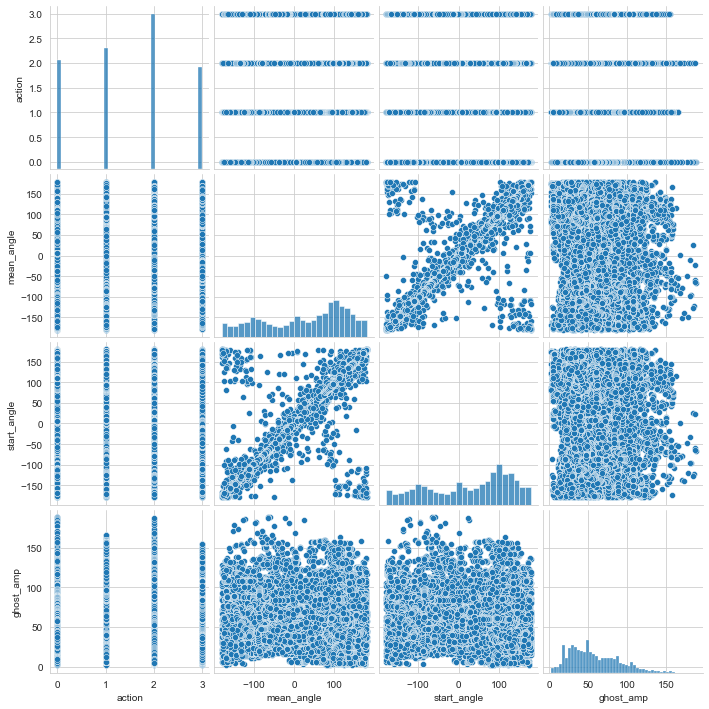

In [20]:
sns.pairplot(finaldf, vars=["action", "mean_angle",'start_angle','ghost_amp'])